In [2]:
import matplotlib.pyplot as plt
import numpy as np

%pylab inline
plt.rc("text", usetex=True)
plt.rc("font", family="serif")
import torch
import swyft
import pickle
DEVICE = 'cpu'

torch.manual_seed(3407)
np.random.seed(3407)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [5]:
with open("./Data/data.pkl", "rb") as f:
    training_data = pickle.load(f)
theta = training_data['theta']
C_IJ = training_data['C_IJ']
sigma_IJ = training_data['sigma_IJ']

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x93 in position 0: invalid start byte

In [6]:
samples = swyft.Samples(x=C_IJ[1:], z=theta[1:])
obs = swyft.Sample(x=C_IJ[0], z=theta[0])

NameError: name 'C_IJ' is not defined

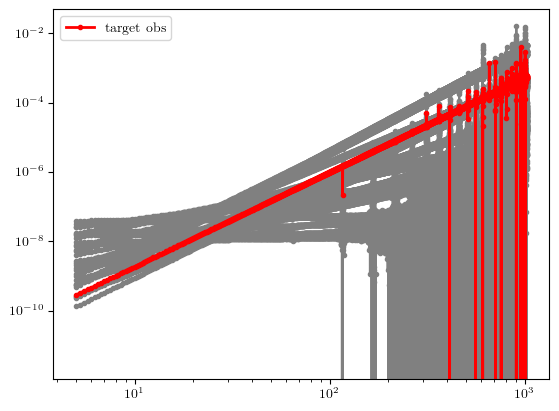

In [ ]:
freq = np.arange(5.00,1024,1/4)
for i in range(30):
    plt.loglog(freq, samples[i]['x'], marker='.', color='0.5')
plt.loglog(freq, obs['x'], marker='.', color='r', lw = 2, label = 'target obs')
plt.legend(loc=0)

In [ ]:
Nbins = len(freq)
marginals = ((0,1),)
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.summarizer = torch.nn.Sequential(torch.nn.Linear(Nbins, 512),
                                              torch.nn.ReLU(),
                                              torch.nn.Linear(512, 64),
                                              torch.nn.ReLU())
        self.logratios = swyft.LogRatioEstimator_1dim(num_features=64, num_params=2, varnames='z')
        
    def forward(self, A, B):
        s = self.summarizer(A['x'])
        logratios = self.logratios(s, B['z'])
#         logratios = self.logratios(A['x'], B['z'])
#         s = self.summarizer(A['x'])
#         s = s.unsqueeze(-1)
        return logratios #self.logratios(s, B['z']), s

In [ ]:
trainer = swyft.SwyftTrainer(accelerator=DEVICE, precision=64)
dm = swyft.SwyftDataModule(samples)
network = Network()
trainer.fit(network, dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name       | Type                   | Params
------------------------------------------------------
0 | summarizer | Sequential             | 2.1 M 
1 | logratios  | LogRatioEstimator_1dim | 42.9 K
------------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
17.305    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Reloading best model: /home/haowen.zhong/SBI/SinglePL/lightning_logs/version_19/checkpoints/epoch=1-step=2500.ckpt


In [ ]:
obs['z']

array([2.25589496e-08, 2.72434660e+00])

In [ ]:
from scipy.stats import loguniform
prior_Omega_ref =  loguniform.rvs(1e-8, 1e-7, size=100_000)
prior_alpha = random.uniform(0,3,size=100_000)
prior_samples = np.column_stack([prior_Omega_ref, prior_alpha])

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 1250it [00:00, ?it/s]

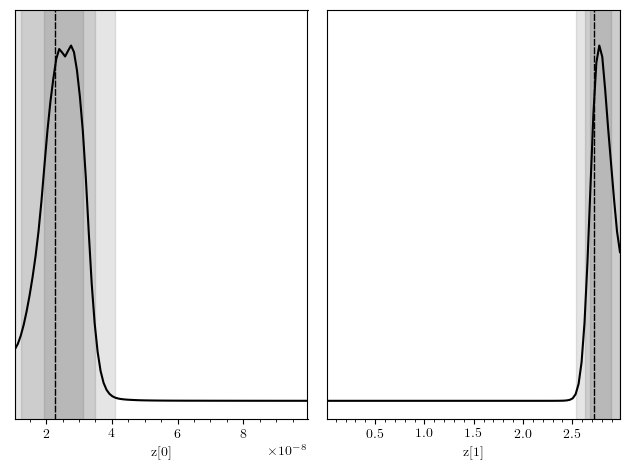

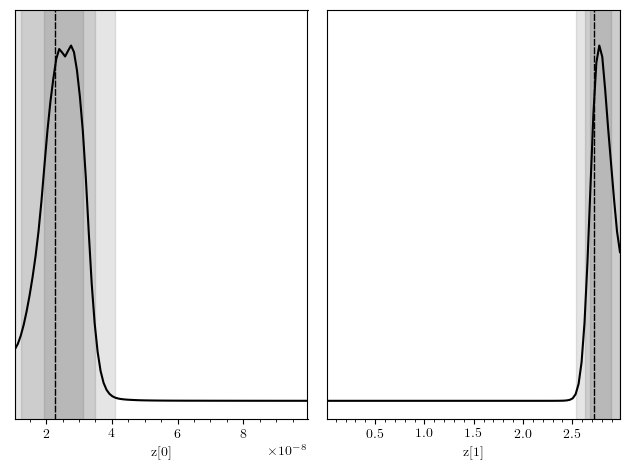

In [ ]:
prior_samples = swyft.Samples(z = prior_samples)
predictions = trainer.infer(network, obs, prior_samples)

truth = {k: v for k, v in zip(["z[%i]"%i for i in range(2)], obs['z'])}
swyft.plot_posterior(predictions, ["z[%i]"%i for i in range(2)], truth=truth)

# Multiple rounds

In [273]:
import scipy.stats as stats
import scipy

pi = np.pi
sqrt = np.sqrt
H100 = 3.241e-18
h    = 0.679
H0   = h * H100
class Simulator(swyft.Simulator):
    def __init__(self, fref, psd, gamma, T_obs, Nbins=4076, bounds=None):
        super().__init__()
        self.fref      = fref
        self.psd       = psd
        self.gamma     = gamma
        self.T_obs     = T_obs
        
        self.transform_samples = swyft.to_numpy32
        self.Nbins = Nbins
        self.freq = np.linspace(5., 1024 + (1024-5)/Nbins , Nbins)
        self.sample_z = swyft.RectBoundSampler([stats.loguniform(1e-8,1e-7), #alpha
                                                stats.uniform(0,3)], #omega alpha
                                                bounds = bounds) #bounds changes range of the prior

    def psd_interp(self):
        return scipy.interpolate.interp1d(self.psd[:,0], self.psd[:,1])(self.freq)
    
    def gamma_interp(self):
        return scipy.interpolate.interp1d(self.gamma[:, 0], self.gamma[:, 1])(self.freq)
    
    def sigma(self):
        numerator = (20*pi**2*self.freq**3)**2 * self.psd_interp()**2
        denomenator = (3*H0**2)**2 * 8*self.gamma_interp()**2
        T = 1/(self.freq[1]-self.freq[0])
        N = 2*self.T_obs // T - 1
        return np.sqrt(numerator/denomenator/N)
    
    def C_groundtruth(self, z):
        Omega_ref = z[0]
        alpha     = z[1]
        C_hat_ij = Omega_ref * (self.freq/self.fref)**alpha
        return C_hat_ij
    
    def build(self, graph):
        z = graph.node('z', self.sample_z)
        m = graph.node('m', self.C_groundtruth, z)
        x = graph.node("x", lambda m: m + np.random.normal(0, self.sigma()), m)

In [279]:
Nbins = len(freq)
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
#         self.summarizer = torch.nn.Sequential(torch.nn.Linear(Nbins, 2048),
#                                               torch.nn.ReLU(),
#                                               torch.nn.Linear(2048, 512),
#                                               torch.nn.ReLU(),
#                                               torch.nn.Linear(512, 256),
#                                               torch.nn.ReLU(),
#                                               torch.nn.Linear(256, 128),
#                                               torch.nn.ReLU(),
#                                               torch.nn.Linear(128, 32),
#                                               torch.nn.ReLU(),
#                                               torch.nn.Linear(32, 8),
#                                               torch.nn.ReLU(),
#                                              )
        self.summarizer = torch.nn.Linear(Nbins, 16)
        self.logratios = swyft.LogRatioEstimator_1dim(num_features=16, num_params=2, varnames='z')
        
    def forward(self, A, B):
        s = self.summarizer(A['x'])
        logratios = self.logratios(s, B['z'])
#         logratios = self.logratios(A['x'], B['z'])
#         s = self.summarizer(A['x'])
#         s = s.unsqueeze(-1)
        return logratios #self.logratios(s, B['z']), s

  0%|          | 0/100 [00:00<?, ?it/s]

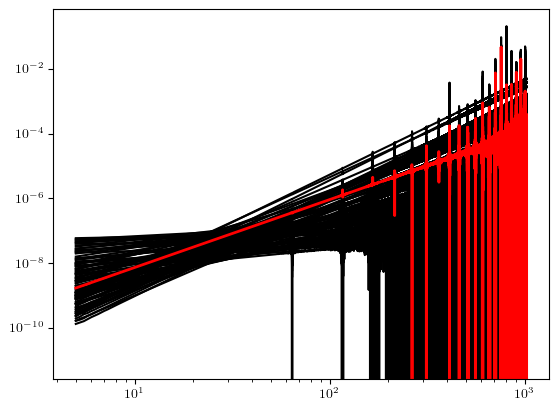

In [280]:
fref = 25
CE_PSD = np.genfromtxt("../cosmic_explorer_40km_for_paper.txt")
CE_PSD[0, 0]  = 4.99999999999999999
CE_PSD[:, 1] = CE_PSD[:, 1]**2
gamma_HL = np.genfromtxt("../gamma_HL.txt")
T_obs = 365 * 24 * 3600

sim = Simulator(fref, CE_PSD, gamma_HL, T_obs, bounds=None)
obs = sim.sample(conditions = {'z': np.array([5e-8, 2.1])})
samples = sim.sample(100)
for i in range(len(samples)):
    plt.loglog(sim.freq, samples[i]['x'], 'k')
plt.loglog(sim.freq, obs['x'], 'r', lw=2)

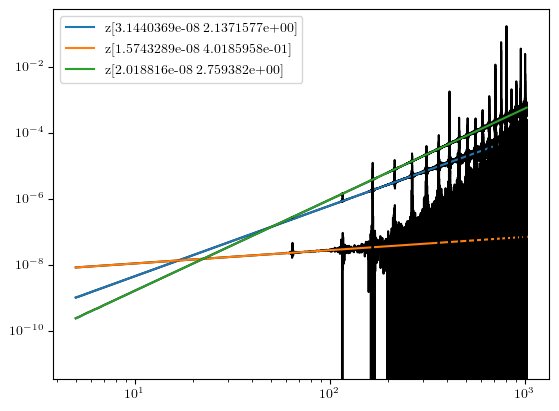

In [281]:
for i in [5, 2, 50]:
    plt.loglog(sim.freq, samples['x'][i], color='k')
    plt.loglog(sim.freq, samples['m'][i], label="z" + str(samples['z'][i]))
plt.legend()

In [282]:
def round(obs, bounds=None):
    sim = Simulator(fref, CE_PSD, gamma_HL, T_obs, bounds=bounds)
    samples = sim.sample(20000) #20000 traiing samples
    dm = swyft.SwyftDataModule(samples, batch_size=64) #traing w samples
    trainer = swyft.SwyftTrainer(accelerator="cpu", precision = 64)
    network = Network()
    trainer.fit(network, dm) #fit network
    prior_samples = sim.sample(N = 10000, targets=['z']) #simulate ratio estimation
    predictions = trainer.infer(network, obs, prior_samples) #predictions
    new_bounds = swyft.collect_rect_bounds(predictions, 'z', (2,), threshold=1e-2) #set new bounds for priors
    return predictions, new_bounds, samples

In [283]:
bounds = None
prediction_rounds = []
bounds_rounds = []
samples_rounds = []

for n in range(5):
    predictions, bounds, samples = round(obs, bounds = bounds)
    prediction_rounds.append(predictions)
    bounds_rounds.append(bounds)
    samples_rounds.append(samples)
    print("New bounds:", bounds)

  0%|          | 0/20000 [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/haowen.zhong/.local/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name       | Type                   | Params
------------------------------------------------------
0 | summarizer | Linear                 | 65.2 K
1 | logratios  | LogRatioEstimator_1dim | 36.7 K
------------------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.816     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/haowen.zhong/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/haowen.zhong/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Reloading best model: /home/haowen.zhong/SBI/SinglePL/lightning_logs/version_34/checkpoints/epoch=1-step=500.ckpt


  0%|          | 0/10000 [00:00<?, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 250it [00:00, ?it/s]

New bounds: tensor([[1.0001e-08, 9.9996e-08],
        [1.6087e+00, 2.7660e+00]], dtype=torch.float64)


  0%|          | 0/20000 [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name       | Type                   | Params
------------------------------------------------------
0 | summarizer | Linear                 | 65.2 K
1 | logratios  | LogRatioEstimator_1dim | 36.7 K
------------------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.816     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Reloading best model: /home/haowen.zhong/SBI/SinglePL/lightning_logs/version_35/checkpoints/epoch=5-step=1500.ckpt


  0%|          | 0/10000 [00:00<?, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 250it [00:00, ?it/s]

New bounds: tensor([[4.2303e-08, 9.6994e-08],
        [2.0280e+00, 2.3821e+00]], dtype=torch.float64)


  0%|          | 0/20000 [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name       | Type                   | Params
------------------------------------------------------
0 | summarizer | Linear                 | 65.2 K
1 | logratios  | LogRatioEstimator_1dim | 36.7 K
------------------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.816     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Reloading best model: /home/haowen.zhong/SBI/SinglePL/lightning_logs/version_36/checkpoints/epoch=3-step=1000.ckpt


  0%|          | 0/10000 [00:00<?, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 250it [00:00, ?it/s]

New bounds: tensor([[4.2307e-08, 6.3757e-08],
        [2.0280e+00, 2.1254e+00]], dtype=torch.float64)


  0%|          | 0/20000 [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name       | Type                   | Params
------------------------------------------------------
0 | summarizer | Linear                 | 65.2 K
1 | logratios  | LogRatioEstimator_1dim | 36.7 K
------------------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.816     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Reloading best model: /home/haowen.zhong/SBI/SinglePL/lightning_logs/version_37/checkpoints/epoch=0-step=250.ckpt


  0%|          | 0/10000 [00:00<?, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 250it [00:00, ?it/s]

New bounds: tensor([[4.2309e-08, 6.3756e-08],
        [2.0628e+00, 2.1254e+00]], dtype=torch.float64)


  0%|          | 0/20000 [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name       | Type                   | Params
------------------------------------------------------
0 | summarizer | Linear                 | 65.2 K
1 | logratios  | LogRatioEstimator_1dim | 36.7 K
------------------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.816     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Reloading best model: /home/haowen.zhong/SBI/SinglePL/lightning_logs/version_38/checkpoints/epoch=2-step=750.ckpt


  0%|          | 0/10000 [00:00<?, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 250it [00:00, ?it/s]

New bounds: tensor([[4.2314e-08, 5.3901e-08],
        [2.0628e+00, 2.1254e+00]], dtype=torch.float64)


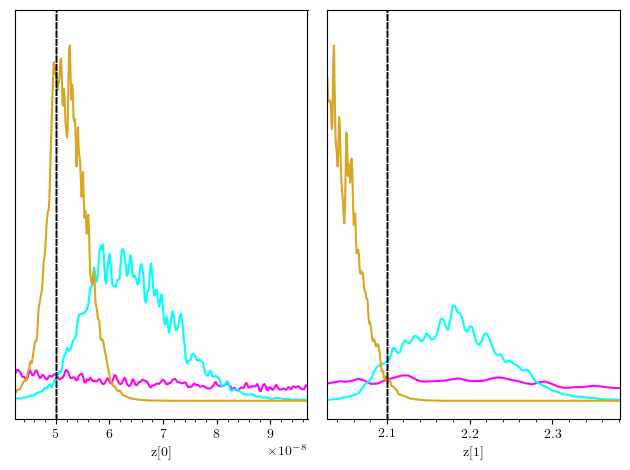

In [284]:
#pink is flat log uniform. Blue is second round, Yellow is third round
truth = {k: v for k, v in zip(["z[%i]"%i for i in range(2)], obs['z'])}
colors = ['fuchsia', 'cyan', 'goldenrod']
fig = None
for i in range(3):
    fig = swyft.plot_posterior(prediction_rounds[i], ["z[%i]"%i for i in range(2)], fig=fig, truth=truth, smooth = 1, bins = 400, contours = False, color=colors[i])